# **Inversión 1D con datos reales (YellowStone)**
**Elaborado por:** \
Ivan Camilo Caballero Jaimes 2210623\
Johan Enrique Páez Romero 2210631\
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Liberías

In [1]:
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

## Visualizar datos en formato .edi

En el contexto de los estudios magnetotelúricos (MT), los archivos .edi (Electrical Data Interchange) son un formato estándar para 
almacenar y compartir datos. Estos incluyen información sobre la ubicación del sitio, parámetros de adquisición y **Tensores de impedancia**. En esta sección con ayuda de la librería MTpy y el modulo Z vamos a visualizar y explorar el contenido de los datos en formato .edi 

In [9]:
mc = MTCollection()
mc.open_collection(
    filename=Path().cwd().parent.parent.joinpath("Repositorio","Funciones_transferencia","yellowstone_mt_collection_02.h5")
)

24:07:21T16:39:18 | INFO | line:677 |mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file c:\Users\USUARIO\Desktop\Magnetotelurica\Repositorio\Funciones_transferencia\yellowstone_mt_collection_02.h5 in mode a


In [11]:
bb_edi_path = Path().cwd().parent.parent.joinpath("Repositorio","Data") #Debes ajustar esta ruta según dónde estén tus archivos
for edi_filename in mc.make_file_list(bb_edi_path, file_types=["edi"]):
    mt_object = MT(edi_filename)
    mt_object.read()

    # update the survey id
    mt_object.survey_metadata.id = "MC"
    mc.add_tf(mt_object)

24:07:21T16:40:43 | WARNING | line:1056 |mth5.mth5 | get_survey | /Experiment/Surveys/MC does not exist, check survey_list for existing names.


In [5]:
mc.dataframe.head()

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,YNP05S,MC,44.696556,-110.967917,2079.35,YNP05S,none,True,True,False,0.003906,1024.002621,<HDF5 object reference>,<HDF5 object reference>


In [12]:
Sonde_1 = mc.get_tf("YNP05S", survey="MC") #Extraemos el archivo ubicado anteriormente y lo guardamos en una variable
print(Sonde_1)
type(Sonde_1)

Station: YNP05S
--------------------------------------------------
	Survey:            MC
	Project:           Yellowstone
	Acquired by:       UW/OSU
	Acquired date:     2017-08-01
	Latitude:          44.697
	Longitude:         -110.968
	Elevation:         2079.350
	Declination:   
		Value:     0.0
		Model:     WMM
	Coordinate System: geographic
	Impedance:         True
	Tipper:            True
	N Periods:     37
	Period Range:
		Min:   3.90625E-03 s
		Max:   1.02400E+03 s
	Frequency Range:
		Min:   9.76560E-04 Hz
		Max:   2.56000E+02 Hz


mtpy.core.mt.MT

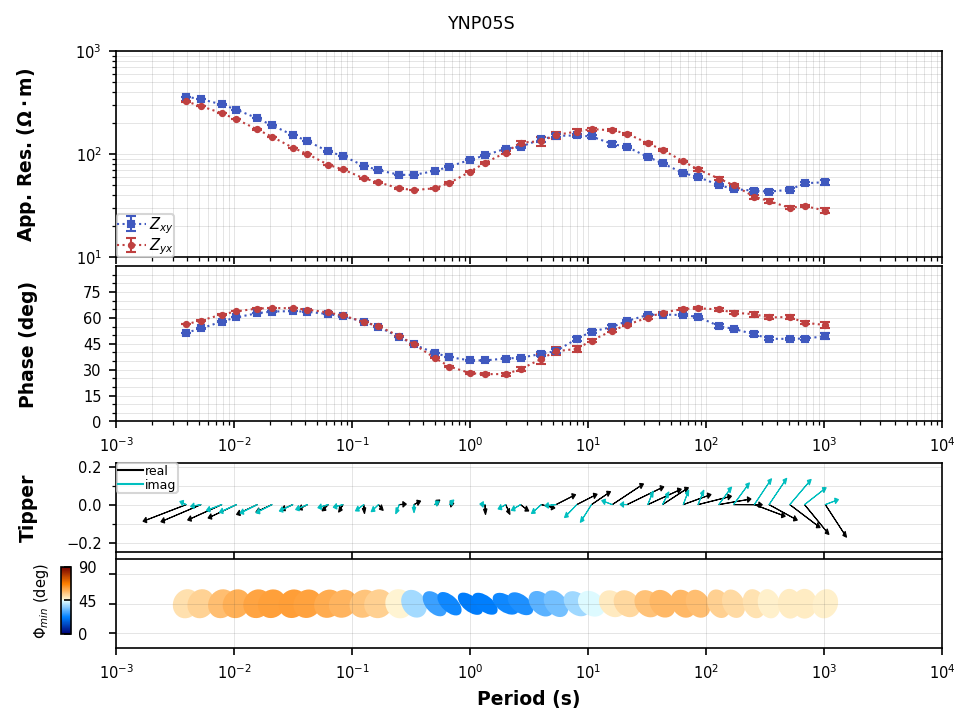

In [14]:
plot_response = Sonde_1.plot_mt_response() # vemos la respuesta de los datos

## Extracción de datos y Skin Depth 

Podemos extraer los datos de frecuencias, resistividad aparente y fase para luego almacenarlos en un array de números complejos.\
Es importante constatar de que todos tengan la misma cantidad de datos antes de unirlos.

In [18]:
frecuencias = Sonde_1.Z.frequency.copy()
rho_app = Sonde_1.Z.res_det.copy()      
phase = Sonde_1.Z.phase_det.copy() 
error=Sonde_1.Z.det_error.copy()

Creamos un Dataframe con estos datos para calcular a profundidad máxima de adquisición.

In [19]:
df=pd.DataFrame({"frecuencias":frecuencias,"rho_app":rho_app,"Fase":phase}) 
print(df.head())

   frecuencias     rho_app       Fase
0        256.0  352.045055  53.829872
1        192.0  325.869242  56.142852
2        128.0  284.205124  59.869679
3         96.0  250.495633  62.062985
4         64.0  203.475217  64.078638


In [20]:
def calcular_profundidades_piel(df):
    # Calcular la profundidad de piel para cada fila
    df['Profundidad de piel (m)'] = 503 * np.sqrt(df['rho_app'] / df['frecuencias'])
    return df
df=calcular_profundidades_piel(df)
print(df.head())
d_max = df.iloc[0]['Profundidad de piel (m)']
d_min = df.iloc[-1]['Profundidad de piel (m)']

print(f"La profundidad máxima es: {d_min:.2f} metros")
print(f"La profundidad mínima es: {d_max:.2f} metros")

   frecuencias     rho_app       Fase  Profundidad de piel (m)
0        256.0  352.045055  53.829872               589.857528
1        192.0  325.869242  56.142852               655.298322
2        128.0  284.205124  59.869679               749.512623
3         96.0  250.495633  62.062985               812.516984
4         64.0  203.475217  64.078638               896.878800
La profundidad máxima es: 95367.46 metros
La profundidad mínima es: 589.86 metros


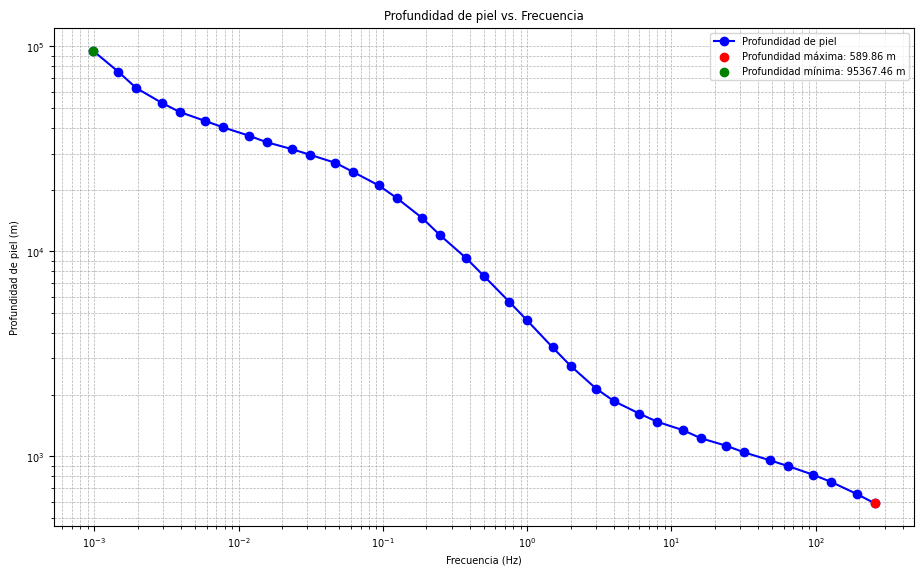

In [21]:
plt.figure(figsize=(10, 6))
plt.loglog(df['frecuencias'], df['Profundidad de piel (m)'], marker='o', linestyle='-', color='b', label='Profundidad de piel')
plt.scatter(df.iloc[0]['frecuencias'], d_max, color='r', label=f'Profundidad máxima: {d_max:.2f} m', zorder=5)
plt.scatter(df.iloc[-1]['frecuencias'], d_min, color='g', label=f'Profundidad mínima: {d_min:.2f} m', zorder=5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Profundidad de piel (m)')
plt.title('Profundidad de piel vs. Frecuencia')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

Creamos nuestro dobs, que será una variable compleja con los datos de rho_app y phase asociados a cada frecuencia 

In [12]:
frecuencias = df['frecuencias'].values
rho_app = df['rho_app'].values
phase = df['Fase'].values        
#Reescribimos el dobs con el rango de datos que sí nos sirven
dobs = np.empty((0,))  
for r, p in zip(rho_app, phase):
    dobs = np.concatenate((dobs, [r, p]))

## Inversión 1D

Debemos definir los parámetros de inversión. Debemos definir un layer_thicknesses_inv cuyo valor sea cercano a la profundida máxima de adquisición. 

In [68]:
dz = 56
n_layer = 33
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]
print("El espesor total del modelo será:", layer_thicknesses_inv.sum(), "metros") #Imprimimos el espesor total que tendrá nuestro modelo

El espesor total del modelo será: 95430.1297240671 metros


In [27]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
  
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]
    inv = inversion.BaseInversion(inv_prob, directives_list)

    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict


In [28]:
relative_error_rho = 0.05
floor_phase = 2
rho_app = df['rho_app'].values
phase = phase = df['Fase'].values  
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()      #error.mean()   #np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
# standard_deviation += dobs_error
rho_0 = 100
rho_ref = 100.
recovered_model, output_dict = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=1.1,
    coolingRate=1,
    chi_factor=1
)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.20e+04  6.78e+03  0.00e+00  6.78e+03    3.80e+03      0              
   1  2.91e+04  4.43e+02  3.13e-03  5.34e+02    3.63e+02      0              
   2  2.65e+04  7.10e+01  6.38e-03  2.40e+02    1.16e+02      0   Skip BFGS  
   3  2.40e+04  5.07e+01  6.35e-03  2.03e+02    2.93e+01      0   Skip BFGS  
   4  2.19e+04  4.08e+01  6.61e-03  1.85e+02    1.10e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.777

In [29]:
target_misfit = dobs.size / 2.       
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [30]:
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

### Gráficas

Valores para el Layers_thikness_inv propuestos en el github:\
Profundidad de aquisición: 95367.46 metros \
Espesor acumulado de: **59094.078449942404 metros** \
dz = 50 \
n_layer = 31 \
z_factor = 1.2 \
coolingFactor=1.1   #Este valor cambió para que no disminuyera tan rápido beta \
La inverisión se iteró 5 veces. El mejor modelo fue el 4.

#### Curva de Tikhonov

In [31]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=5, description='iteration', max=5, min=1), RadioButtons(description='sca…

#### Modelo de resistividades 

In [32]:
def plot_inverted_model_and_data(iteration):
    dpred = output_dict[iteration]['dpred']
    m = output_dict[iteration]['m']
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
    )
    # ax0.legend()
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_ylabel("Profundidad (m)")
    #ax0.set_xlim(1, 10000)
    # ax0.set_xlim(1, 1e4)
    ax0.set_xlim(10,100000)

    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-AppRho.')
    ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-AppRho.')

    ax_1 = ax.twinx()
    ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
    ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
    ax.set_xlabel("Period (s)")
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Resistividad Aparente ($\Omega$m)")
    ax_1.set_ylabel("Fase ($\degree$)")
    # ax.legend(bbox_to_anchor=(1.1,1))
    ax.legend(loc=2)
    ax_1.legend(loc=1)
    ax.set_ylim(1, 10000)
    ax_1.set_ylim(0, 90)    
    ax0.set_xlim(1, 10000)
    plt.show()
interact(
    plot_inverted_model_and_data, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration)
)

interactive(children=(IntSlider(value=5, description='iteration', max=5, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_inverted_model_and_data(iteration)>

### Consideraciones

Valores para el Layers_thikness_inv propuestos en el github:\
Profundidad de aquisición: 95367.46 metros \
Espesor acumulado de: **59094.078449942404 metros** \
dz = 50 \
n_layer = 31 \
z_factor = 1.2 \
coolingFactor=1.1   #Este valor cambió para que no disminuyera tan rápido beta \
La inverisión se iteró 5 veces. El mejor modelo fue el 4. 

Valores propuestos por Johan: \
profundidad de adquisición: 95367.46 metros \
Espesor acumulado del laver_thikness_inv: **95430.1297240671 metros** \
dz = 56 \
n_layer = 33 \
z_factor = 1.2 \
coolingFactor=1.1   #Este valor cambió para que no disminuyera tan rápido beta \
La inverisión se iteró 6 veces. El mejor modelo fue el 5.